In [1]:
import re
import numpy as np
from countrycode import countrycode
import phonenumbers
from phonenumbers.phonenumberutil import region_code_for_number
import geopandas

In [22]:
import nltk
from nltk.corpus import stopwords
from tqdm.notebook import tqdm_notebook
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 10)

In [3]:
argentina_area_codes = pd.read_csv("./argentina-area-codes.csv")

In [ ]:
argentina = geopandas.read_file("./localidades.shp")
argentina.plot()

## Load toxicity model

In [4]:
from detoxify import Detoxify
model = Detoxify('multilingual')
results = model.predict(['jajajajajaja que hijo de puta'])
results

/home/juan/WhatsappAnalyzer/mundialdelectura/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


{'toxicity': [0.9959450364112854],
 'severe_toxicity': [0.019979896023869514],
 'obscene': [0.1270299106836319],
 'identity_attack': [0.022107917815446854],
 'insult': [0.10652615875005722],
 'threat': [0.004996316507458687],
 'sexual_explicit': [0.16550682485103607]}

In [5]:
def get_toxicity(message):
  return model.predict(message)["toxicity"]

## READ FROM TXT FILE

In [6]:
path = Path("./Chat_as_DF.pkl")
if path.is_file():
    after_process = pd.read_pickle(path)

In [26]:
splitted_chat = []
with open("./Chat de WhatsApp con Mundial de Lectura/chats.txt", "r") as chat:
    all_chat = chat.read().replace("\n", " ")
    splitted_chat = re.findall("\d{1,2}\/\d{1,2}\/\d{4}, \d{1,2}:\d{2} - \+[()\d\w\s-]+: [\s\S]*?(?=\d{1,2}\/\d{1,2}\/\d{4}, \d{1,2}:\d{2} - \+|$)", all_chat)

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_5941/927023349.py:4: SyntaxWarning: invalid escape sequence '\d'
  splitted_chat = re.findall("\d{1,2}\/\d{1,2}\/\d{4}, \d{1,2}:\d{2} - \+[()\d\w\s-]+: [\s\S]*?(?=\d{1,2}\/\d{1,2}\/\d{4}, \d{1,2}:\d{2} - \+|$)", all_chat)


In [27]:
def get_argentina_region(code):
    rows = argentina_area_codes[argentina_area_codes["code"] == code]
    if len(rows):
        return list(rows["localidad"]), rows.iloc[-1]["provincia"]
    else:
        return None, None

In [81]:
get_argentina_region(1)

[None, None]

In [84]:
def process_line(line):
    #10/3/2024, 12:44 - +54 9 11 3763-1285: Muchas Gracias !!! Ya compre entradas.
    regex_result = re.search("^(\d{1,2}\/\d{1,2}\/\d{4}), (\d\d:\d\d) - (\+(\d*) (?:9 (\d*)|([()\d\w\s-]*))([()\d\w\s-]*)): ([\s\S]*)$", line)
    Message_Raw = line
    date = regex_result.group(1)
    time = regex_result.group(2)
    phone_number = phonenumbers.parse(regex_result.group(3))
    country = region_code_for_number(phone_number)
    argentina_town,argentina_province = get_argentina_region(int(regex_result.group(5))) if country == "AR" else (None,None)
    message = regex_result.group(8)
    toxicity = get_toxicity(message)
    date = datetime.strptime(f"{date} {time}", "%d/%m/%Y %H:%M")
    return pd.DataFrame([{
            "User": phone_number,
            "plain_phone_number": regex_result.group(3),
            "Country": country,
            "Message_Raw": Message_Raw,
            "Argentina_Province": argentina_province,
            "Argentina_Location": argentina_town,
            "Message_Clean": message,
            "Message_Only_Text": message.lower() ,
            "Toxicity": toxicity,
            "Date": date,
            "Hour": date.hour,
            "Day_of_Week": date.weekday()
           }])

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_5941/471829634.py:3: SyntaxWarning: invalid escape sequence '\d'
  regex_result = re.search("^(\d{1,2}\/\d{1,2}\/\d{4}), (\d\d:\d\d) - (\+(\d*) (?:9 (\d*)|([()\d\w\s-]*))([()\d\w\s-]*)): ([\s\S]*)$", line)


In [85]:
after_process = pd.DataFrame()
with tqdm_notebook(total=len(splitted_chat)) as progress_bar:
    for line in splitted_chat:
        try:
            processed_line = process_line(line)
            after_process = pd.concat([after_process, processed_line])
        except Exception as err:
            print(f"EXCEPTION {err} on line {line}")
            pass
        finally:
            progress_bar.update(1)
            
after_process.to_pickle("Chat_as_DF.pkl")

  0%|          | 0/7284 [00:00<?, ?it/s]

In [7]:
first_interaction_for_each_person = after_process.groupby("plain_phone_number").first().reset_index()

## Messages sent by country

In [8]:
first_interaction_for_each_person.groupby(["Country"]).count().sort_values(ascending=False,by="User")

,plain_phone_number,User,Message_Raw,Argentina_Province,Argentina_Location,Message_Clean,Message_Only_Text,Toxicity,Date,Hour,Day_of_Week
Country,,,,,,,,,,,
AR,357,357,357,357,357,357,357,357,357,357,357
CO,13,13,13,0,0,13,13,13,13,13,13
UY,9,9,9,0,0,9,9,9,9,9,9
MX,6,6,6,0,0,6,6,6,6,6,6
CL,5,5,5,0,0,5,5,5,5,5,5
ES,5,5,5,0,0,5,5,5,5,5,5
US,4,4,4,0,0,4,4,4,4,4,4
PE,4,4,4,0,0,4,4,4,4,4,4
GB,2,2,2,0,0,2,2,2,2,2,2


## Message sent by province

In [95]:
first_interaction_for_each_person.groupby(["Argentina_Province"]).count().sort_values(ascending=False,by="User")

,plain_phone_number,User,Country,Message_Raw,Argentina_Location,Message_Clean,Message_Only_Text,Toxicity,Date,Hour,Day_of_Week
Argentina_Province,,,,,,,,,,,
AMBA,215,215,215,215,215,215,215,215,215,215,215
BUENOS AIRES,46,46,46,46,46,46,46,46,46,46,46
SANTA FE,23,23,23,23,23,23,23,23,23,23,23
CORDOBA,18,18,18,18,18,18,18,18,18,18,18
MENDOZA,11,11,11,11,11,11,11,11,11,11,11
NEUQUEN,10,10,10,10,10,10,10,10,10,10,10
CHUBUT,7,7,7,7,7,7,7,7,7,7,7
TUCUMAN,5,5,5,5,5,5,5,5,5,5,5
ENTRE RIOS,4,4,4,4,4,4,4,4,4,4,4


## Messages by location

In [9]:
first_interaction_for_each_person["stringified_argentina_location"] = first_interaction_for_each_person["Argentina_Location"].astype(str)
first_interaction_for_each_person.groupby("stringified_argentina_location").count().sort_values(ascending=False, by="User")

,plain_phone_number,User,Country,Message_Raw,Argentina_Province,Argentina_Location,Message_Clean,Message_Only_Text,Toxicity,Date,Hour,Day_of_Week
stringified_argentina_location,,,,,,,,,,,,
['AMBA'],215,215,215,215,215,215,215,215,215,215,215,215
None,59,59,59,59,0,0,59,59,59,59,59,59
"['CAPITAN BERMUDEZ', 'CARCARAA', 'CORONEL ARNOLD', 'FUNES', 'IBARLUCEA', 'PEREZ', 'ROLDAN', 'ROSARIO', 'SAN JERONIMO SUR', 'SOLDINI', 'VILLA GOBERNADOR GALVEZ', 'ZAVALLA']",11,11,11,11,11,11,11,11,11,11,11,11
"['BOUWER', 'COLONIA TIROLESA', 'CORDOBA', 'EL QUEBRACHAL (PROV. CORDOBA)', 'FERREYRA', 'GUIAZU', 'JUAREZ CELMAN', 'LICEO', 'LOS BOULEVARES', 'MALAGUEO', 'MALVINAS ARGENTINAS', 'MONTE CRISTO', 'SANTA ISABEL (PROV. CORDOBA)', 'TOLEDO', 'VILLA ESQUIU', 'VILLA RETIRO']",10,10,10,10,10,10,10,10,10,10,10,10
"['AELO', 'ARROYITO DEL CHOCON', 'BARDA DEL MEDIO', 'BARRIO EX ISLA 10', 'CATRIEL', 'CENTENARIO (PROV. NEUQUEN)', 'CINCO SALTOS', 'COLONIA 25 DE MAYO', 'COLONIA CHICA (PROV. LA PAMPA)', 'COLONIA EL SAUZAL (PROV. LA PAMPA)', 'CONTRALMIRANTE CORDERO', 'CUTRAL CO', 'GENERAL FERNANDEZ ORO', 'LAS PERLAS', 'NEUQUEN', 'PLOTTIER', 'RINCON DE LOS SAUCES', 'SAN PATRICIO DEL CHAAR', 'SAUZAL BONITO', 'SENILLOSA', 'VILLA MANZANO', 'VILLA EL CHOCON']",9,9,9,9,9,9,9,9,9,9,9,9
"['ABASTO', 'BARRIO PARQUE SICARDI', 'BARTOLOME BAVIO', 'LA PLATA', 'LISANDRO OLMOS', 'OLIDEN', 'POBLET']",9,9,9,9,9,9,9,9,9,9,9,9
"['BARRIO EL CASAL', 'BARRIO LA ARMONIA', 'BARRIO PARQUE PEA', 'BARRIO SAN EDUARDO', 'BATAN', 'COLONIA BARRAGAN', 'EL FARO', 'ESTACION CAMET', 'LA BRAVA (PROV. BUENOS AIRES)', 'LAS DOS MARIAS', 'LOS ORTIZ', 'MAR CHIQUITA', 'MAR DEL PLATA', 'PLAYA CHAPADMALAL', 'SANTA CELINA', 'SANTA CLARA DEL MAR', 'SIERRA DE LOS PADRES']",8,8,8,8,8,8,8,8,8,8,8,8
"['AGRELO', 'ALTO DEL OLVIDO', 'BARRANCAS (PROV. MENDOZA)', 'BLANCO ENCALADA', 'COLONIA / LOTEO NEVOT', 'COLONIA ITALIA', 'COLONIA SAN FRANCISCO', 'COLONIA SUIZA', 'COLONIA TRES DE MAYO', 'CRUZ DE PIEDRA', 'CHACRAS DE CORIA', 'EL CARRIZAL DE ABAJO', 'EL CARRIZAL DE ARRIBA', 'EL CHICAL', 'FRAY LUIS BELTRAN (PROV. MENDOZA)', 'JOCOLI', 'JOCOLI VIEJO', 'LA PALMERA', 'LA PEGA', 'LAS VIOLETAS', 'LAVALLE (PROV. MENDOZA)', 'LOTEO CAVERO Y BARRIO LA COLMENA', 'LUJAN DE CUYO', 'MAIPU (PROV. MENDOZA)', 'MENDOZA', 'RODEO DE LA CRUZ', 'RODEO DEL MEDIO', 'SAN JOSE (PROV. MENDOZA, DTO. LAVALLE)', 'SGUAZZINI', 'TERMAS VILLAVICENCIO', 'UGARTECHE']",6,6,6,6,6,6,6,6,6,6,6,6
"['GARDEY', 'TANDIL', 'VELA']",6,6,6,6,6,6,6,6,6,6,6,6


<Axes: xlabel='plain_phone_number'>

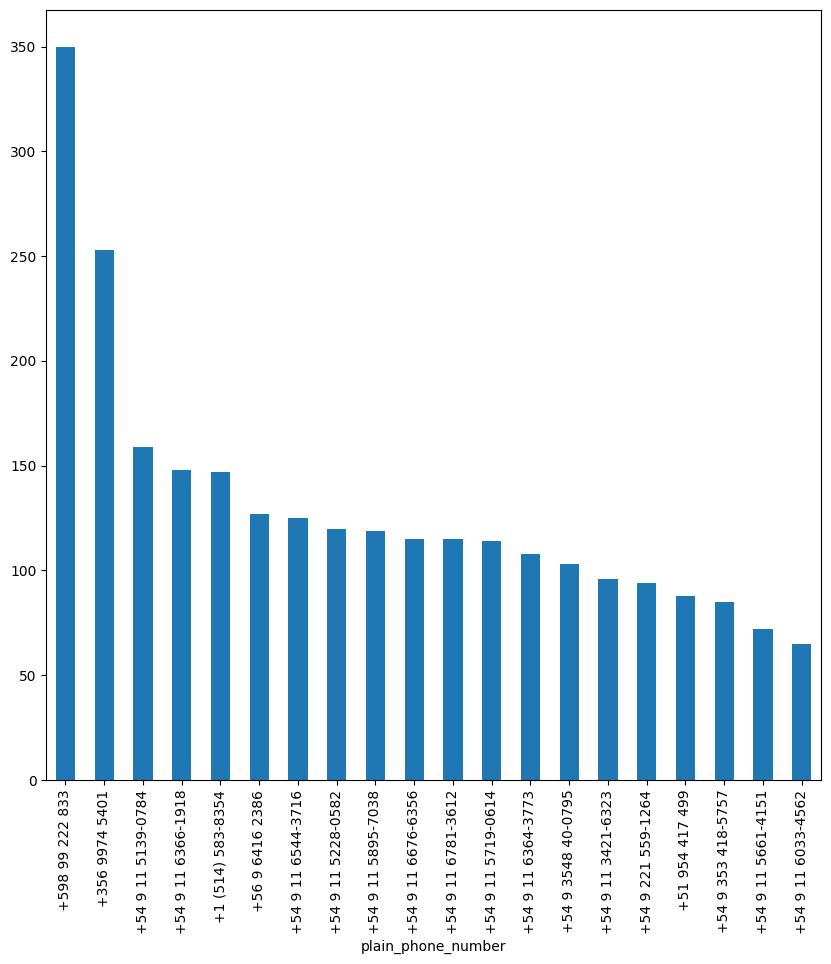

In [23]:
messages_by_person = after_process.groupby("plain_phone_number")
messages_by_person["plain_phone_number"].count().sort_values(ascending=False).head(20).plot(kind="bar")

## Get messages for a person

In [13]:
print(after_process[after_process["plain_phone_number"] == "54 9 221 602-2258"]["Message_Clean"])

Series([], Name: Message_Clean, dtype: object)


## Day with max number of messages for each person

In [15]:
max_messages_on_a_day_per_person = after_process.groupby(["plain_phone_number", after_process["Date"].dt.date]).count().sort_values(by="Hour").groupby(level=0).tail(1).sort_values(ascending=False, by="Hour")

max_messages_on_a_day_per_person["Date"].reset_index(name="Total messages")

,plain_phone_number,Date,Total messages
0,+598 99 222 833,2024-04-06,34
1,+54 9 11 3287-5499,2024-05-01,26
2,+54 9 11 5719-0614,2024-04-08,26
3,+54 9 11 6033-4562,2024-03-30,24
4,+54 9 11 6366-1918,2024-03-19,24
...,...,...,...
411,+54 9 11 3577-0440,2024-05-03,1
412,+54 9 11 5049-7243,2024-03-15,1
413,+54 9 11 3652-8898,2024-04-30,1
414,+34 626 55 36 95,2024-04-27,1


## Day of the week with most messages for each person

In [16]:
import calendar

messages_by_day_of_week = after_process.groupby(["plain_phone_number", after_process["Date"].dt.weekday]).count().sort_values(by="Hour")["Date"]

matrix_of_messages = messages_by_day_of_week.unstack()
matrix_of_messages.columns = map(lambda x: calendar.day_name[x],matrix_of_messages.columns)
matrix_of_messages.style.background_gradient(cmap="RdYlGn")

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
plain_phone_number,,,,,,,
+1 (202) 251-3116,1.000000,1.000000,nan,nan,nan,nan,nan
+1 (484) 802-1106,nan,1.000000,nan,nan,2.000000,3.000000,4.000000
+1 (514) 583-8354,31.000000,27.000000,15.000000,15.000000,19.000000,28.000000,12.000000
+1 (787) 530-3113,nan,nan,nan,1.000000,nan,nan,nan
+1 (832) 231-5647,2.000000,1.000000,4.000000,2.000000,nan,nan,nan
+1 (954) 806-8077,1.000000,nan,3.000000,1.000000,1.000000,nan,nan
+33 6 27 39 28 02,nan,nan,3.000000,1.000000,nan,nan,nan
+34 626 55 36 95,nan,nan,nan,1.000000,nan,1.000000,nan
+34 651 17 37 23,nan,nan,nan,4.000000,7.000000,3.000000,16.000000


## Top 10 days with higher number of messages

In [17]:
higher_number_of_messages = after_process.groupby(after_process["Date"].dt.date).count()

for day in higher_number_of_messages.nlargest(columns="Hour", n=10).iterrows():
    print(f'Day (YYYY-MM-dd): {day[0]} - Number of messages: {day[1]["Hour"]}')

Day (YYYY-MM-dd): 2024-03-14 - Number of messages: 355
Day (YYYY-MM-dd): 2024-03-21 - Number of messages: 321
Day (YYYY-MM-dd): 2024-03-13 - Number of messages: 307
Day (YYYY-MM-dd): 2024-05-03 - Number of messages: 282
Day (YYYY-MM-dd): 2024-03-19 - Number of messages: 279
Day (YYYY-MM-dd): 2024-04-08 - Number of messages: 268
Day (YYYY-MM-dd): 2024-03-15 - Number of messages: 237
Day (YYYY-MM-dd): 2024-03-27 - Number of messages: 234
Day (YYYY-MM-dd): 2024-03-20 - Number of messages: 232
Day (YYYY-MM-dd): 2024-03-22 - Number of messages: 211


## Hour with the higher number of messages overall

In [18]:
higher_number_of_messages_of_hour = after_process.groupby(after_process["Date"].dt.hour).count()


print(f'Hour: {higher_number_of_messages_of_hour.idxmax()["Date"]} - Number of messages: {higher_number_of_messages.max()["Date"]}')

Hour: 10 - Number of messages: 355


## Most messages in an hour

In [19]:
higher_number_of_messages = after_process.groupby([after_process["Date"].dt.date, after_process["Date"].dt.hour]).count()

print(f'Day (YYYY-MM-dd): {higher_number_of_messages.idxmax()["Date"][0]} - Hour: {higher_number_of_messages.idxmax()["Date"][1]} - Number of messages: {higher_number_of_messages.max()["Date"]}')

Day (YYYY-MM-dd): 2024-04-08 - Hour: 8 - Number of messages: 65


## Messages per hour

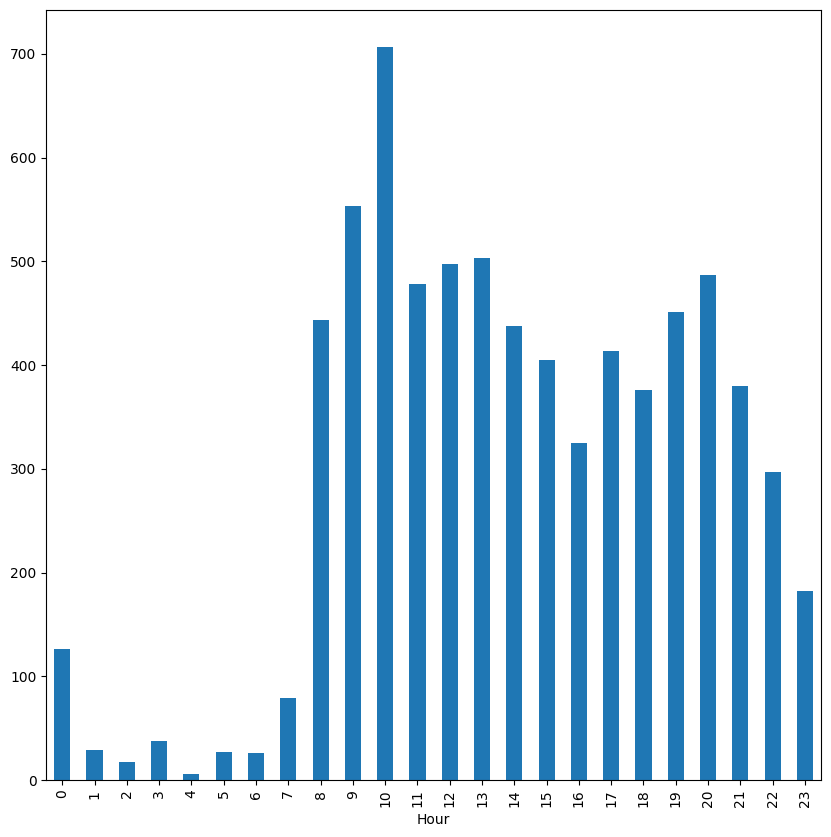

In [24]:
messages_per_hour = after_process.groupby("Hour")["Hour"].count().plot(kind="bar")

## Messages per day of the week

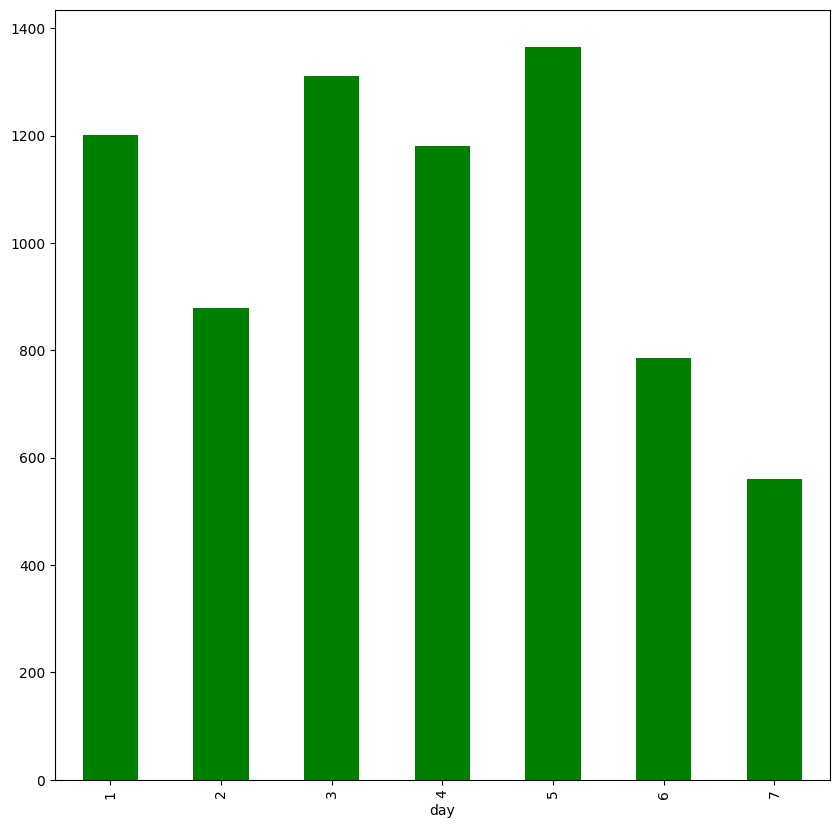

In [25]:
messages_per_hour = after_process.groupby(after_process["Date"].dt.isocalendar().day)["Hour"].count().plot(kind="bar", color="green")

## Messages per week of the each year

array([<Axes: title={'center': '2024'}, xlabel='Date'>], dtype=object)

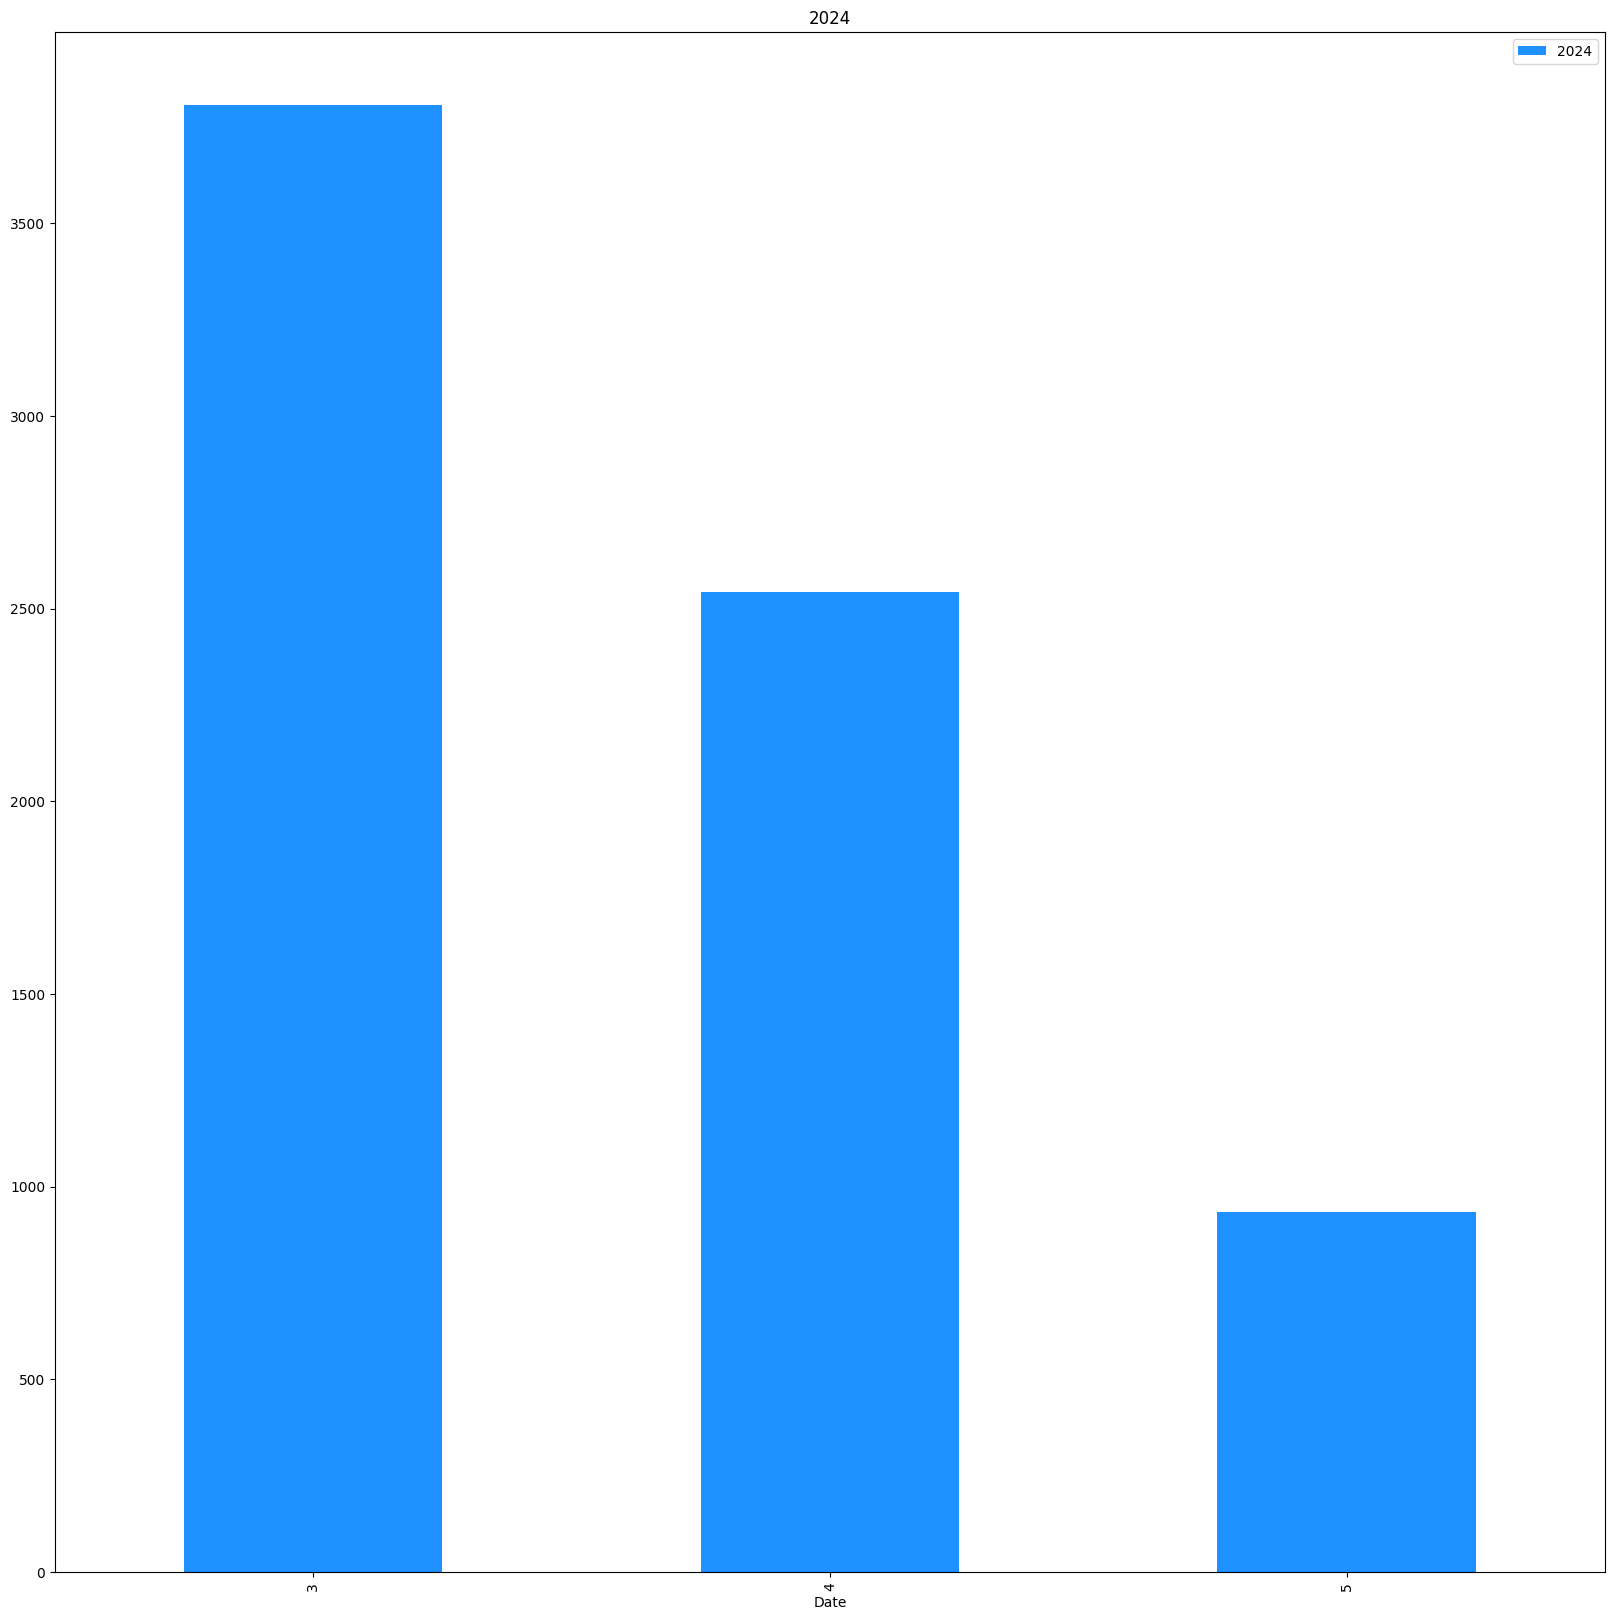

In [24]:
after_process.groupby([after_process["Date"].dt.month, after_process["Date"].dt.year])["Hour"].count().unstack(level=1).plot(kind="bar", color="dodgerblue", subplots=True)

## Message metrics per person

In [27]:
column_aggregation = {
    "avg_message_length": lambda x: np.mean(x["Message_Clean"].str.len()),
    "total_char_length": lambda x: np.sum(x["Message_Clean"].str.len()),
    "total_messages": lambda x: len(x)
}
messages_aggregated = pd.DataFrame()
for label, function in column_aggregation.items():
    messages_aggregated[label] = messages_by_person.apply(function)

/tmp/ipykernel_5495/2570549389.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  messages_aggregated[label] = messages_by_person.apply(function)
/tmp/ipykernel_5495/2570549389.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  messages_aggregated[label] = messages_by_person.apply(function)
/tmp/ipykernel_5495/2570549389.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. Th

In [28]:
messages_aggregated.sort_values("avg_message_length",ascending=False)

,avg_message_length,total_char_length,total_messages
plain_phone_number,,,
+54 9 221 602-2258,594.5,1189,2
+54 9 11 5920-4058,555.0,555,1
+54 9 11 6897-6797,551.0,551,1
+54 9 11 5165-9032,488.0,488,1
+54 9 261 360-1318,457.0,457,1
...,...,...,...
+54 9 351 300-9517,8.5,17,2
+54 9 291 506-1120,8.0,8,1
+54 9 261 513-5247,8.0,8,1


## Average length per person

In [29]:
messages_aggregated.sort_values("avg_message_length",ascending=False).style.background_gradient(cmap="RdYlGn")

,avg_message_length,total_char_length,total_messages
plain_phone_number,,,
+54 9 221 602-2258,594.500000,1189,2
+54 9 11 5920-4058,555.000000,555,1
+54 9 11 6897-6797,551.000000,551,1
+54 9 11 5165-9032,488.000000,488,1
+54 9 261 360-1318,457.000000,457,1
+54 9 291 432-4646,397.459459,14706,37
+54 9 2923 54-1692,356.605263,13551,38
+54 9 11 3660-8965,349.277778,6287,18
+54 9 11 5938-4978,324.400000,3244,10


## Amount of characters written by each person

In [30]:
messages_aggregated.sort_values("total_char_length",ascending=False).style.background_gradient(cmap="RdYlGn")

,avg_message_length,total_char_length,total_messages
plain_phone_number,,,
+598 99 222 833,106.694286,37343,350
+356 9974 5401,139.252964,35231,253
+54 9 11 5895-7038,239.588235,28511,119
+1 (514) 583-8354,185.598639,27283,147
+54 9 11 5228-0582,134.241667,16109,120
+56 9 6416 2386,124.818898,15852,127
+598 99 633 276,285.660377,15140,53
+54 9 291 432-4646,397.459459,14706,37
+54 9 2923 54-1692,356.605263,13551,38


## Who laugh the most?

In [31]:
def is_laugh(message):
  reg = re.compile(r"^.*\b[JjeEiIAakKSs]{3,}\b.*$")
  is_jj = re.compile(r"^.*\b[jJ][jJ]\b.*$")
  return bool(reg.match(message)) and bool(not is_jj.match(message))

In [45]:
count_laughs = dict.fromkeys(keys, 0)

for person, messages in messages_by_person:
  print(person)
  for message in messages.iterrows():
    if is_laugh(message[1]["Message_Clean"]):
      count_laughs[person] += 1

plt.bar(list(keys), list(count_laughs.values()))
plt.title("Who laugh the most overall?")
plt.xticks(rotation=90)
plt.show()

print(count_laughs)


NameError: name 'keys' is not defined

In [ ]:
average_laughs = dict.fromkeys(akas_for_each_person.keys(), 0)
for person in count_laughs:
  average_laughs[person] = count_laughs[person] / len(messages_by_person.get_group(person))

plt.bar(list(keys), list(count_laughs.values()))
plt.title("Who laugh the most (probability per message)?")
plt.xticks(rotation=90)
plt.show()

## Average toxicity by person

<Axes: xlabel='User'>

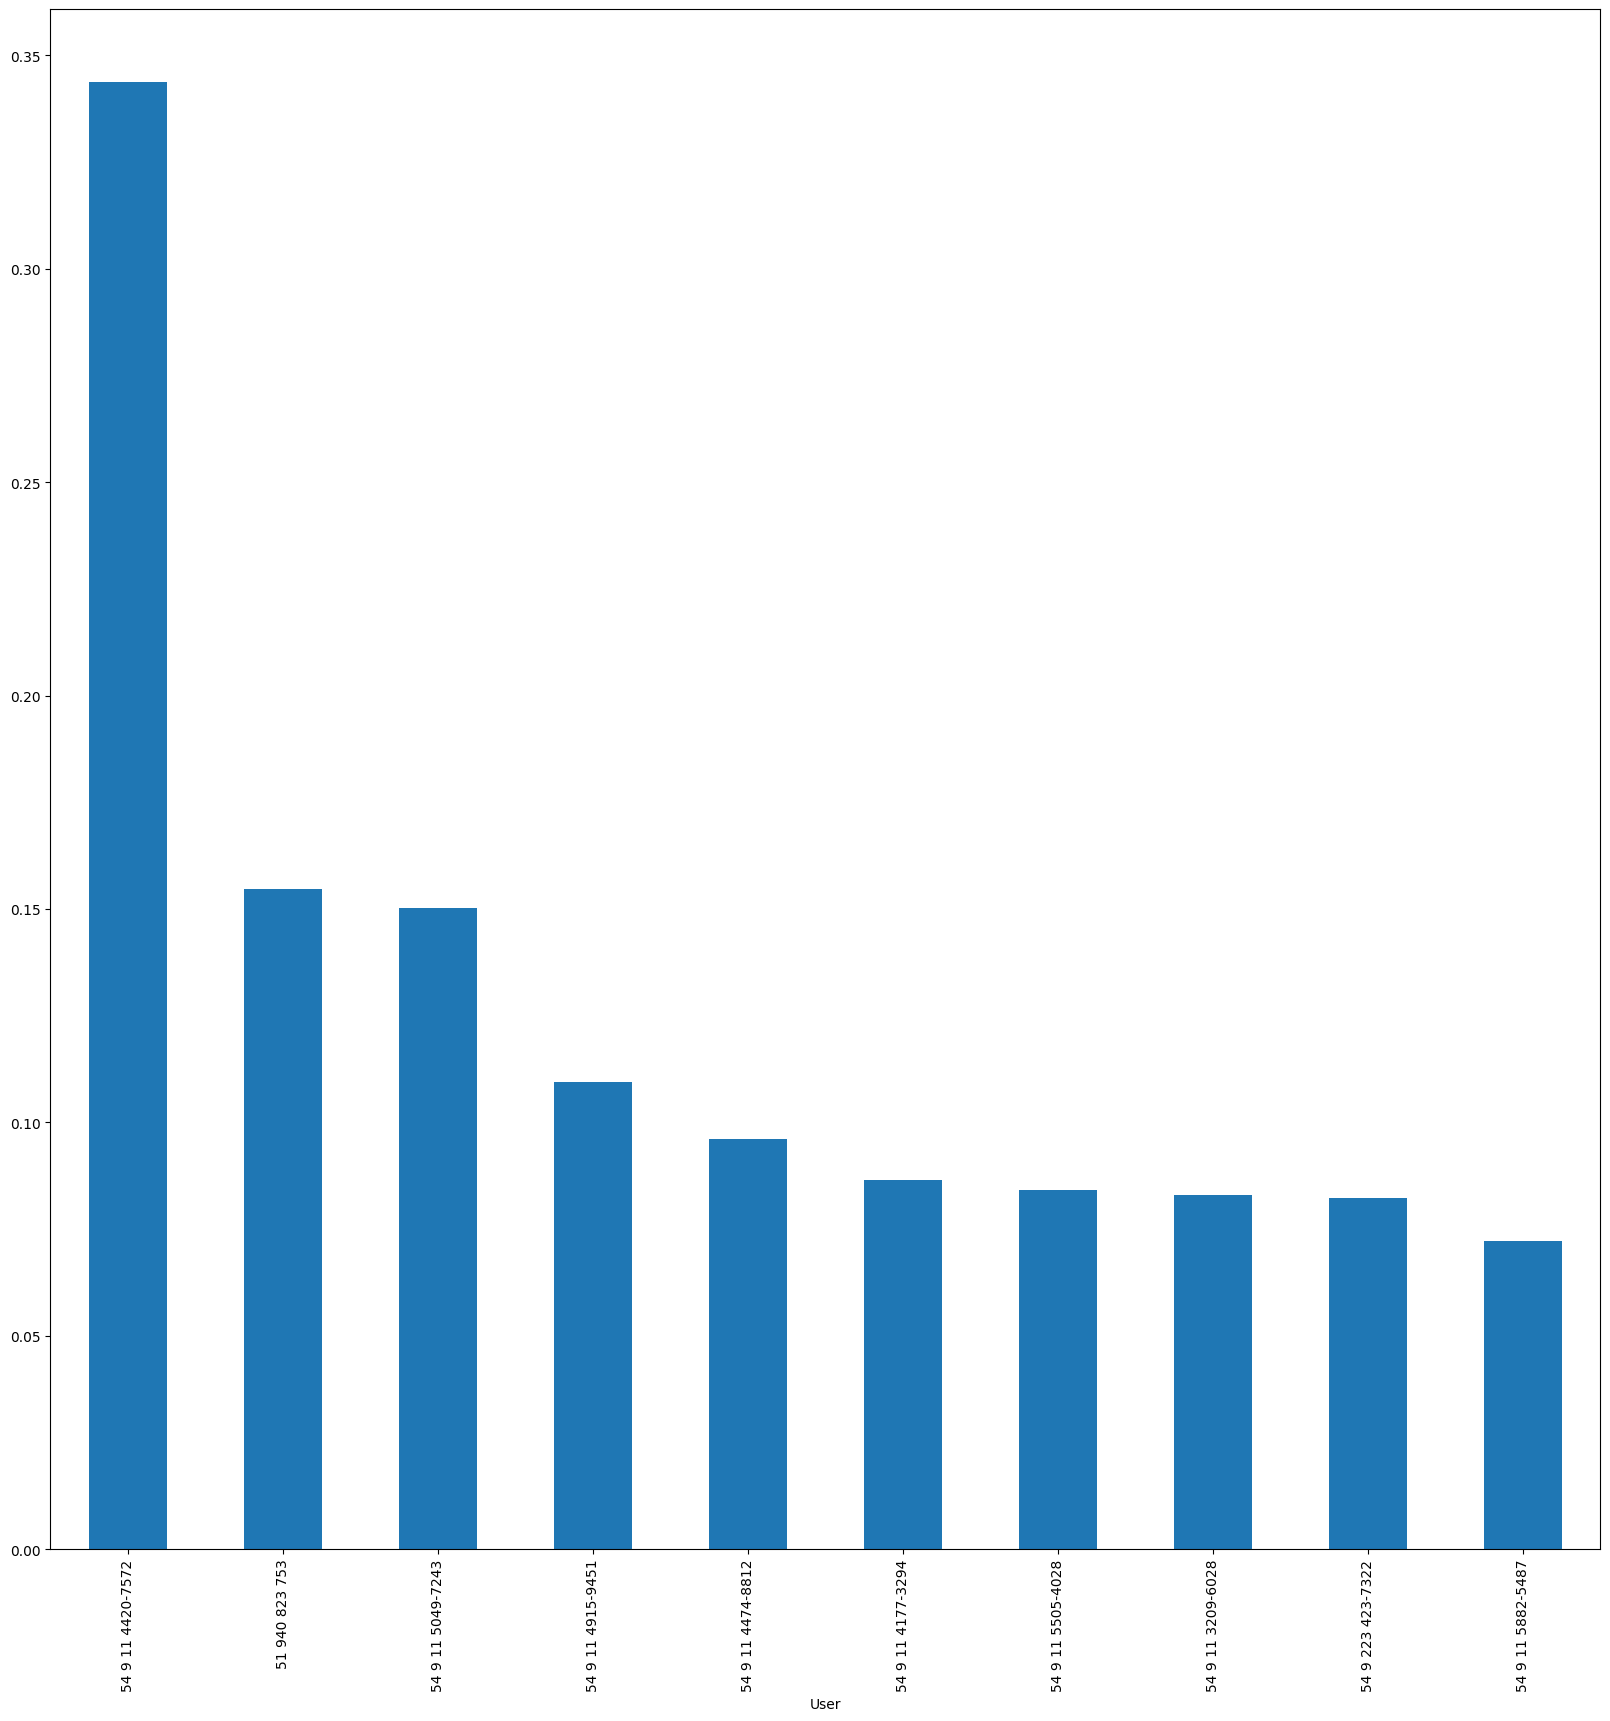

In [60]:
toxic_messages = after_process.groupby("User").mean(numeric_only=True)
toxic_messages["Toxicity"].sort_values(ascending=False).head(10).plot(kind="bar")

### Top 10 most toxic messages

In [48]:
after_process.nlargest(10, "Toxicity")[["Message_Clean", "Toxicity"]].reset_index()

,index,Message_Clean,Toxicity
0,0,Me desvelo sus estúpidos y desubicados comenta...,0.988293
1,0,😅😅 Tenía que ser argentino el muy maldito!,0.980533
2,0,Corto mano corto fierro cuando te mueras vas a...,0.979675
3,0,Dos una cobarde que eliminaste todos tus dicho...,0.976592
4,0,En el sonido y la furia hay un protagonista br...,0.964557
5,0,No voy a dejar de escribir porque una idiota m...,0.964308
6,0,"Hay algo que está más allá de ser peronista, m...",0.950384
7,0,Me parece que la gula de Dante se relaciona al...,0.940821
8,0,"No soy una cobarde, los elimine porque a difer...",0.931517
9,0,LAGO PUELO CUNA DEL LÚPULO Y PEJERREY,0.931170


In [ ]:
from nltk.corpus import stopwords
import nltk
spanish_stopwords = stopwords.words("spanish")
spanish_stopwords.extend(["q", "dsp", "si", "<", ">", "multimedia", "omitido", "omitida", "\u200eaudio", "\u200eimagen", "\u200esticker", "\u200evideo", "\u200egif", "", "Hola", "t", "d", ""])

In [ ]:
nltk.download("punkt")

In [ ]:
import spacy
import spacy_spanish_lemmatizer
nlp = spacy.load("es_core_news_sm")

In [ ]:
import string

In [ ]:
def lemmatize(message):
    return [token.lemma_ for token in nlp(message)]

def remove_word(word):
    return word in spanish_stopwords or is_laugh(word) or len(word) <= 3

def process_message(message):
    return [ token for token in nltk.word_tokenize(message.translate(str.maketrans('', '', string.punctuation))) if not remove_word(token.lower()) ]

In [ ]:
process_message("Hola, como estas vos?")

In [ ]:
messages_without_stopwords = []
for index, message in after_process.iterrows():
    new_message = message.copy()
    new_message["Message_Only_Text"] = " ".join(process_message(message["Message_Only_Text"]))
    messages_without_stopwords.append(new_message)

## Most frequently used words per person

In [49]:
messages_per_person_without_stopwords = dict.fromkeys(keys, [])
for person, messages in messages_by_person:
    for message in messages.iterrows():
        new_message = process_message(message[1]["Message_Only_Text"])
        messages_per_person_without_stopwords[person].extend(new_message)

NameError: name 'keys' is not defined

In [ ]:
most_used_words = dict.fromkeys(akas_for_each_person.keys(), 0)
for person in messages_per_person_without_stopwords:
    print(person)
    most_used_words[person] = Counter(messages_per_person_without_stopwords[person])

In [ ]:
Counter(messages_per_person_without_stopwords["Person2"]).most_common(10)